In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

from sklearn.metrics import f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galloul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading and Sampling the Dataset

In [47]:
# load dataset
raw_df = pd.read_csv("../../data/scraped/unprocessed-data-1.3M.csv")

raw_df["success"] = raw_df.apply(lambda row: 1 if row["Raised Amount"] >= row["Goal Amount"] else 0, axis=1)

# Subsample 2500 samples for each class where success == 1 and success == 0
df = pd.concat([
    raw_df[raw_df['success'] == 1].sample(n=len(raw_df[raw_df['success'] == 1]), random_state=42),
    raw_df[raw_df['success'] == 0].sample(n=len(raw_df[raw_df['success'] == 1]), random_state=42)
], ignore_index=True)

# Display class distribution
class_distribution = df['success'].value_counts()
print("Class Distribution:")
print(class_distribution)

# process into data and labels
X = df['Description'].values
y = df['success'].values

Class Distribution:
success
1    40068
0    40068
Name: count, dtype: int64


In [49]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

# Dataset Preprocessing

In [50]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in str(sen1).lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:10000] # most popular 10k words 
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = labels

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

# Data Splitting

In [51]:
# Split the dataset into train, valid, and test (80-10-10 split)
train_data, temp_data, train_labels, temp_labels = train_test_split(X, y, test_size=0.2, random_state=42)
valid_data, test_data, valid_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

In [52]:
sum(test_labels == 1)/len(test_labels)

0.499500873471425

In [53]:
# Get vocabulary and convert words to indices
stoi = get_stoi(train_data)

# Tokenize the data
train_data_encoded, train_labels_encoded = tokenize(train_data, train_labels, stoi)
valid_data_encoded, valid_labels_encoded = tokenize(valid_data, valid_labels, stoi)
test_data_encoded, test_labels_encoded = tokenize(test_data, test_labels, stoi)

# Padding
seq_len = 512
train_data_padded = padding_(train_data_encoded, seq_len)
valid_data_padded = padding_(valid_data_encoded, seq_len)
test_data_padded = padding_(test_data_encoded, seq_len)

<built-in method get of Counter object at 0x0000028CD63B8C20>


C:\Users\galloul\AppData\Local\Temp\ipykernel_37920\2077052807.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [54]:
# TO BE COMPLETED
# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data_padded)
valid_data_tensor = torch.tensor(valid_data_padded)
test_data_tensor = torch.tensor(test_data_padded)

train_labels_tensor = torch.tensor(train_labels_encoded)
valid_labels_tensor = torch.tensor(valid_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)

# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_data_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Test the DataLoader
for batch in train_loader:
    data_batch, label_batch = batch
    print("Data Batch Shape:", data_batch.shape)
    print("Label Batch Shape:", label_batch.shape)
    break

Data Batch Shape: torch.Size([256, 512])
Label Batch Shape: torch.Size([256])


In [55]:
for (x, y) in test_loader:
    print(len(y[y==1])/len(y))

0.53515625
0.57421875
0.52734375
0.49609375
0.47265625
0.4921875
0.46875
0.52734375
0.484375
0.50390625
0.4765625
0.515625
0.46484375
0.546875
0.4765625
0.53125
0.52734375
0.4921875
0.5078125
0.50390625
0.48828125
0.55859375
0.4765625
0.44140625
0.49609375
0.46484375
0.48046875
0.5234375
0.48046875
0.484375
0.484375
0.4358974358974359


In [56]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        # Input x is expected to be a LongTensor of shape (batch_size, sequence_length)

        embedded = self.embedding(x)
        output, _ = self.rnn(embedded, hidden)

        # Only take the output from the last time step
        output = output[:, -1, :]
        
        output = self.fc(output)
        return output.squeeze(), hidden

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as FF

# Define your sequence classification model
class BaselineModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embedding=None, freeze_embedding=True):
        super(BaselineModel, self).__init__()

        # Embedding layer
        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Linear layer
        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.embedding(x)

        # Average pooling along the sequence dimension
        pooled = embedded.mean(dim=1)

        # Linear layer
        output = self.linear2(self.dropout(self.linear1(pooled)))
        return output.squeeze()


# Training the Logistic Regression Model

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as FF
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchmetrics.functional.classification as F

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

sns.set()

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, val_interval=10, model_type="linear"):
    
    model.train()
    losses = []
    accuracies = []
    f1_scores = []
    auc_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_auc_scores = []
    
    for epoch in range(0, num_epochs+1):
        total_loss = 0.0
        accuracy = 0.0
        f1_score = 0.0
        auc_score = 0.0
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == "rnn":
                outputs, _ = model(x, None)
            else:
                outputs = model(x)
                
            loss = criterion(outputs, y.float())
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            # Update Accuracy metric
            outputs = FF.sigmoid(outputs)
            accuracy += F.binary_accuracy(outputs, y)
            f1_score += F.binary_f1_score(outputs, y)
            auc_score += F.binary_auroc(outputs, y.type(torch.int))
            
        average_loss = total_loss / len(train_loader)
        average_accuracy = accuracy / len(train_loader)
        average_f1 = f1_score / len(train_loader)
        average_auc = auc_score / len(train_loader)
        
        losses.append(average_loss)
        accuracies.append(average_accuracy.item())
        f1_scores.append(average_f1.item())
        auc_scores.append(average_auc.item())
        
        if epoch % val_interval == 0:
            val_loss, val_accuracy, val_f1, val_auc = validate(model, val_loader, criterion, device, model_type=model_type)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy.item())
            val_f1_scores.append(val_f1.item())
            val_auc_scores.append(val_auc.item())
            
            print(f'Epoch {epoch}/{num_epochs},\
                  Training Loss: {average_loss:.4f}, Training Accuracy: {average_accuracy:.2%}\
                  Training F1: {average_f1:.4f}, Training AUC: {average_auc:.2%}\
                  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}\
                  Validation F1: {val_f1:.4f}, Validation AUC: {val_auc:.2%}')            
                  
        
        else:
            print(f'Epoch {epoch}/{num_epochs},\
                  Training Loss: {average_loss:.4f}, Training Accuracy: {average_accuracy:.2%}\
                  Training F1: {average_f1:.4f}, Training AUC: {average_auc:.2%}')

    
    epochs = range(1, len(losses) + 1)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot training and validation losses
    axs[0, 0].plot(epochs, losses, label='Training Loss')
    axs[0, 0].plot(range(0, len(val_losses) * val_interval, val_interval), val_losses, label='Validation Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot validation accuracy
    axs[0, 1].plot(epochs, accuracies, label='Training Accuracy')
    axs[0, 1].plot(range(0, len(val_accuracies) * val_interval, val_interval), val_accuracies, label='Validation Accuracy', marker='o')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('%')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot training and validation F1 scores
    axs[1, 0].plot(epochs, f1_scores, label='Training F1')
    axs[1, 0].plot(range(0, len(val_accuracies) * val_interval, val_interval), val_f1_scores, label='Validation F1', marker='o')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot training and validation AUC scores
    axs[1, 1].plot(epochs, auc_scores, label='Training AUC')
    axs[1, 1].plot(range(0, len(val_accuracies) * val_interval, val_interval), val_auc_scores, label='Validation AUC', marker='o')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('AUC Score')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

def validate(model, val_loader, criterion, device, model_type="linear"):
    model.eval()
    total_loss = 0.0
    accuracy = 0.0
    f1_score = 0.0
    auc_score = 0.0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            
            if model_type == "rnn":
                outputs, _ = model(x, None)
            else:
                outputs = model(x)
                
            loss = criterion(outputs, y.float())
            total_loss += loss.item()
            # Update Accuracy metric
            outputs = FF.sigmoid(outputs)
            accuracy += F.binary_accuracy(outputs, y)
            f1_score += F.binary_f1_score(outputs, y)
            auc_score += F.binary_auroc(outputs, y.type(torch.int))
            
        average_loss = total_loss / len(val_loader)
        average_accuracy = accuracy / len(val_loader)
        average_f1 = f1_score / len(val_loader)
        average_auc = auc_score / len(val_loader)
    return average_loss, average_accuracy, average_f1, average_auc


Epoch 0/50,                  Training Loss: 0.6946, Training Accuracy: 51.04%                  Training F1: 0.4934, Training AUC: 51.75%                  Validation Loss: 0.6910, Validation Accuracy: 51.92%                  Validation F1: 0.6168, Validation AUC: 53.45%
Epoch 1/50,                  Training Loss: 0.6933, Training Accuracy: 51.42%                  Training F1: 0.5029, Training AUC: 52.10%
Epoch 2/50,                  Training Loss: 0.6923, Training Accuracy: 51.72%                  Training F1: 0.5084, Training AUC: 52.76%
Epoch 3/50,                  Training Loss: 0.6925, Training Accuracy: 51.69%                  Training F1: 0.5043, Training AUC: 52.81%
Epoch 4/50,                  Training Loss: 0.6922, Training Accuracy: 51.63%                  Training F1: 0.4826, Training AUC: 52.89%
Epoch 5/50,                  Training Loss: 0.6918, Training Accuracy: 51.98%                  Training F1: 0.5069, Training AUC: 53.05%
Epoch 6/50,                  Training Loss: 0

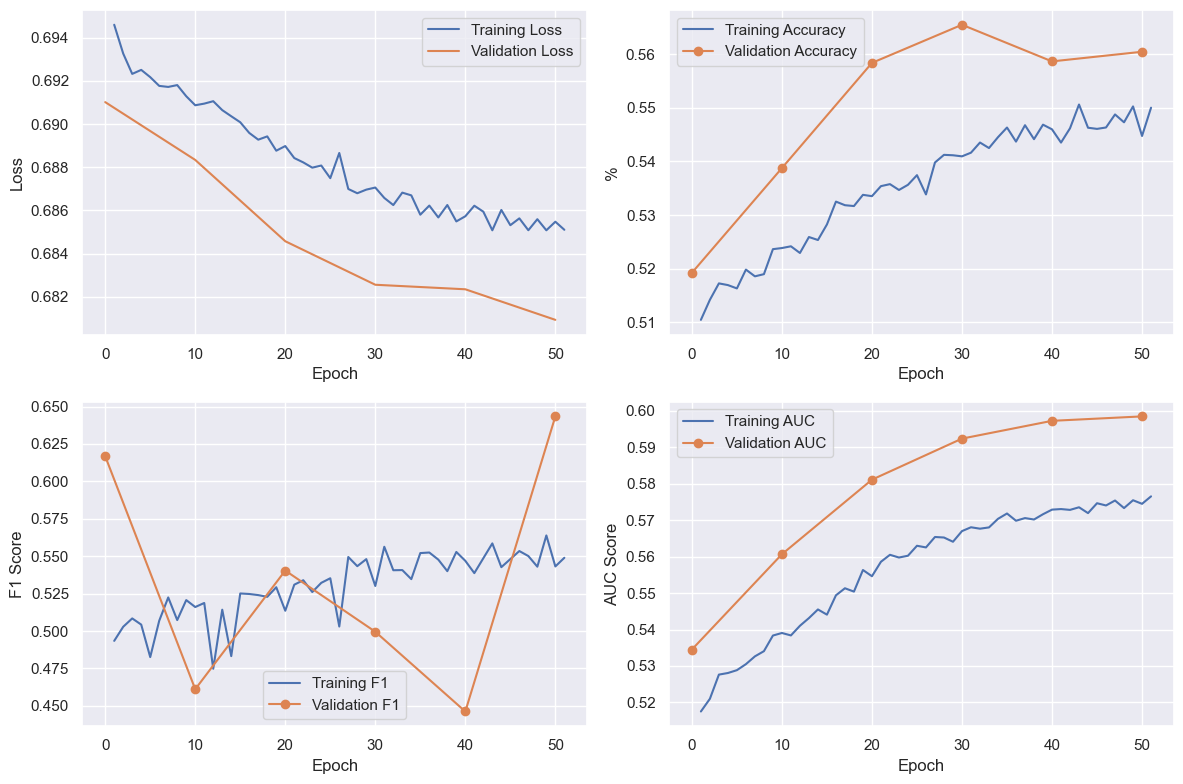

In [59]:
embedding_dim = 300  
lr = 1e-3
num_epochs = 50
glove = GloVe(name='6B', dim=300)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineModel(len(stoi)+1, embedding_dim, pretrained_embedding=glove.vectors)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.BCEWithLogitsLoss()
#
model.to(device)
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=num_epochs, val_interval=10, model_type="linear")

In [60]:
# Print the number of parameters for the logistic regression model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

90601

In [61]:
# logistic regression performance on test set
validate(model, test_loader, criterion=criterion, device=device)

(0.6849189605563879,
 tensor(0.5470, device='cuda:0'),
 tensor(0.6284, device='cuda:0'),
 tensor(0.5816, device='cuda:0'))

# Training the LSTM Model

Epoch 0/30,                  Training Loss: 0.6932, Training Accuracy: 50.80%                  Training F1: 0.4905, Training AUC: 51.14%                  Validation Loss: 0.6919, Validation Accuracy: 51.81%                  Validation F1: 0.4865, Validation AUC: 52.75%
Epoch 1/30,                  Training Loss: 0.6914, Training Accuracy: 51.96%                  Training F1: 0.4859, Training AUC: 53.09%                  Validation Loss: 0.6914, Validation Accuracy: 51.84%                  Validation F1: 0.4909, Validation AUC: 53.06%
Epoch 2/30,                  Training Loss: 0.6903, Training Accuracy: 52.54%                  Training F1: 0.5038, Training AUC: 54.12%                  Validation Loss: 0.6910, Validation Accuracy: 51.87%                  Validation F1: 0.5130, Validation AUC: 53.28%
Epoch 3/30,                  Training Loss: 0.6894, Training Accuracy: 53.18%                  Training F1: 0.5244, Training AUC: 54.92%                  Validation Loss: 0.6908, Validation 

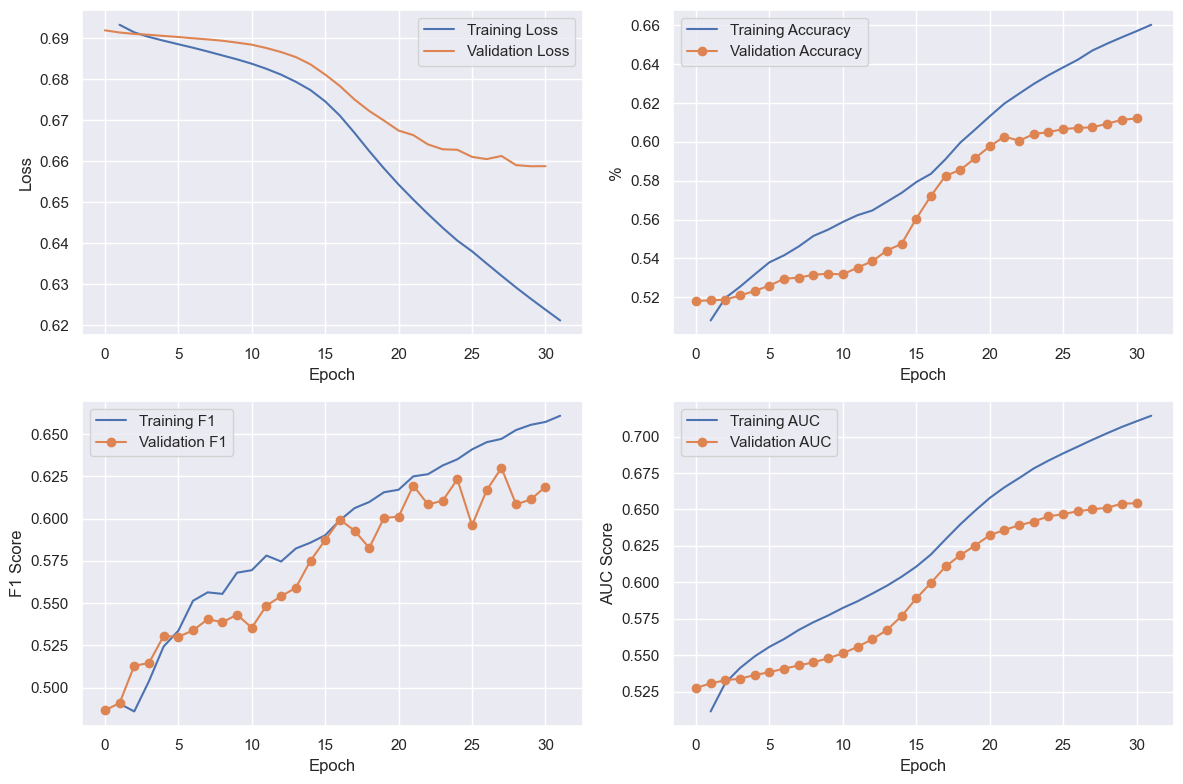

In [62]:
lr = 4e-5
num_epochs = 30

glove = GloVe(name='6B', dim=300)
vocab_size = len(stoi) + 1 
embed_size = 256 
hidden_size = 128 
output_size =  2 
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentRNN(len(stoi)+1, embedding_dim=embed_size, hidden_dim=hidden_size, output_dim=1)

optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
criterion = nn.BCEWithLogitsLoss()
#
model.to(device)
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=num_epochs, val_interval=1, model_type = "rnn")

In [63]:
# Print the number of parameters for the LSTM model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

2758017

In [64]:
# LSTM performance on test set
validate(model, test_loader, criterion=criterion, device=device, model_type="rnn")

(0.6667241472750902,
 tensor(0.6026, device='cuda:0'),
 tensor(0.6050, device='cuda:0'),
 tensor(0.6424, device='cuda:0'))